In [1]:
import matplotlib.pyplot as plt
import polars as pl
from scipy import stats
import seaborn as sns

from lib import (
    load_dataset,
    compute_accuracy_results,
    process_parameter_dataset,
    process_runtime_dataset,
    validate_parameter_dataset,
    apply_hypothesis_test,
    save_figure,
    save_table,
    normalized,
    format_network_types,
)

pl.Config.set_fmt_str_lengths(36);

## Experiment 1: Parameters

In [10]:
parameter = "send_coefficient"
parameter_title = parameter.replace('_', ' ').capitalize()
df = load_dataset("send-coefficient")
validate_parameter_dataset(df)

In [4]:
results = compute_accuracy_results(
    process_parameter_dataset(df),
    parameter=parameter,
    percentiles=[0, 0.01, 0.1, *range(1, 7), 21],
)

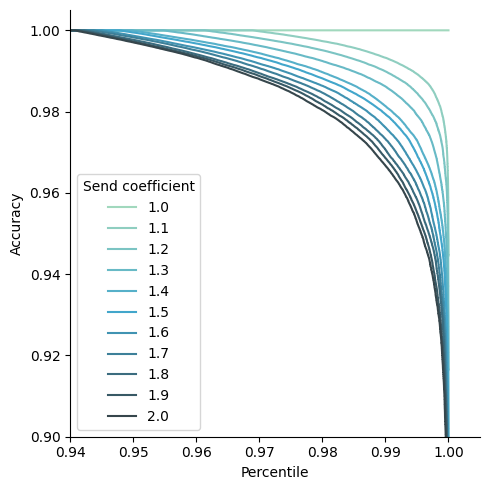

In [22]:
output_path = 'outputs/accuracy_aggregate'

min_parameter = results.counts[parameter].min()
data = results.tabular.filter(pl.col(parameter) >= min_parameter)

g = sns.FacetGrid(
    data,
    hue=parameter,
    xlim=(0.94, 1.005),
    ylim=(0.90, 1.005),
    palette="GnBu_d",
    height=5,
    legend_out=False,
)

g.map_dataframe(sns.ecdfplot, y="accuracy", complementary=True)
g.set_axis_labels("Percentile", "Accuracy")
g.add_legend(title=parameter_title)

save_figure(g, output_path)
save_table(results.percentiles, output_path)

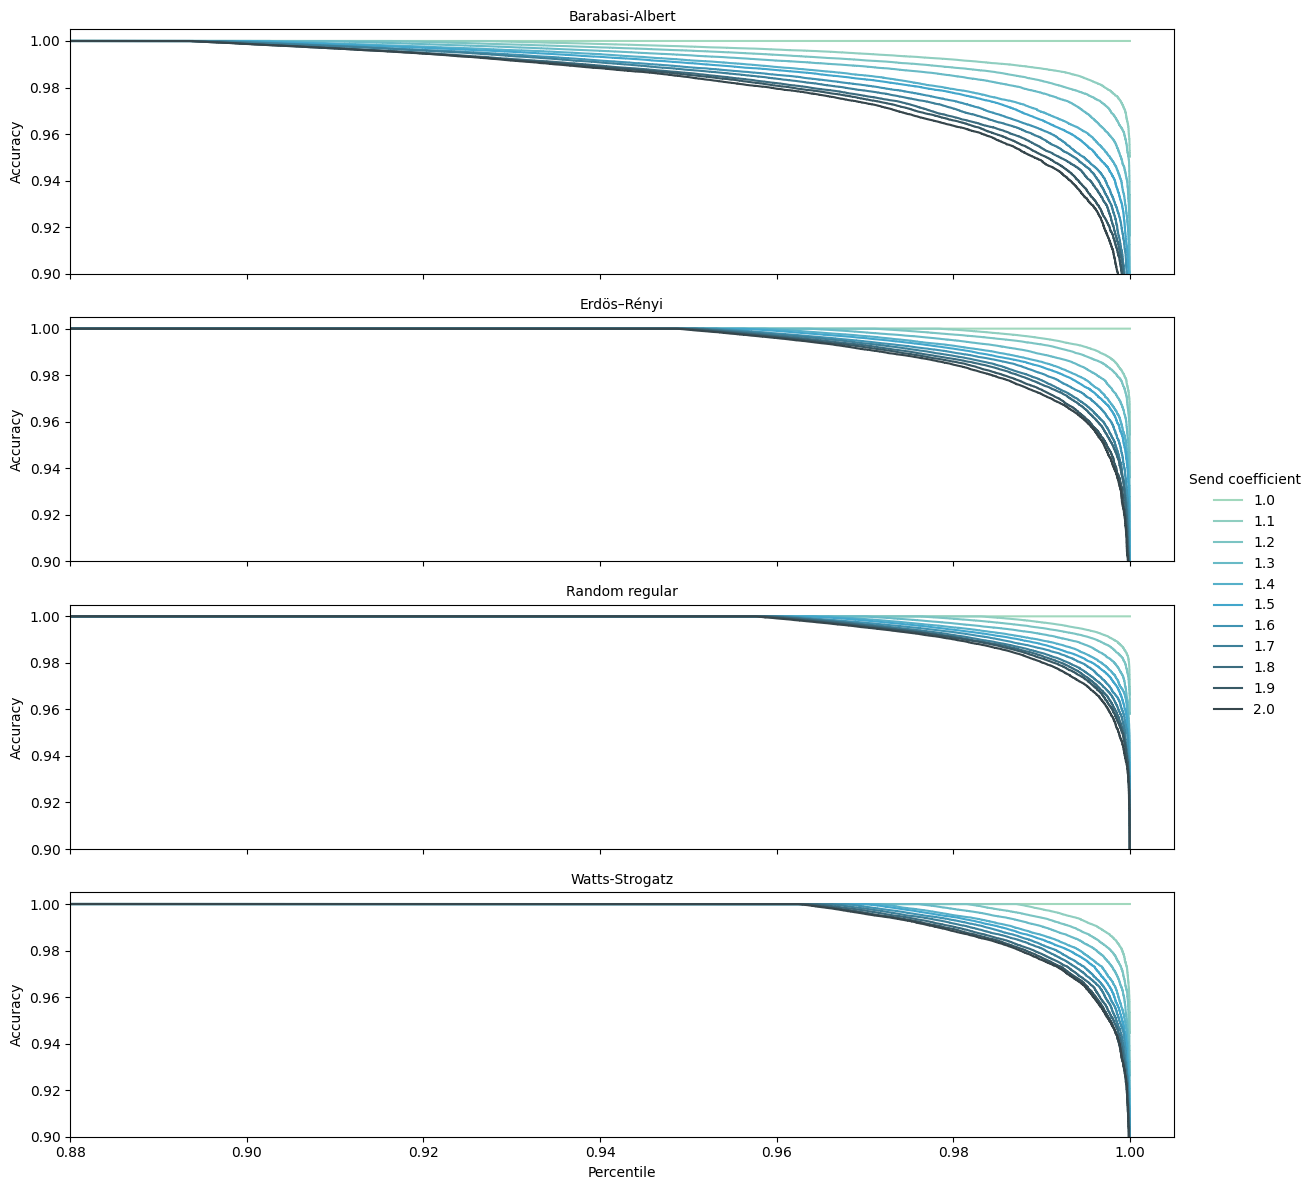

In [23]:
output_path = 'outputs/accuracy_network-type'

data = format_network_types(data)

g = sns.FacetGrid(
    data,
    col="network_type",
    col_order=data["network_type"].unique().sort(),
    hue=parameter,
    col_wrap=1,
    xlim=(0.88, 1.005),
    ylim=(0.90, 1.005),
    despine=False,
    palette="GnBu_d",
    aspect=4,
)
g.map_dataframe(sns.ecdfplot, y="accuracy", complementary=True)
g.set_axis_labels("Percentile", "Accuracy")
g.set_titles("{col_name}")
g.add_legend(title=parameter_title)

save_figure(g, output_path)

In [ ]:
data = df
data = data.filter(pl.col("send_coefficient") >= 1)
data = data.with_columns(pl.col("n_receives").list.sum())
data = data.with_columns(
    normalized("n_receives", by="max")
    .over("dataset_id", "network_source", "score_source")
    .alias("n_receives_norm")
)
percentiles = results.percentiles.filter(pl.col("send_coefficient") >= 1)
data = data.join(percentiles, on='send_coefficient')

g = sns.FacetGrid(
    data.to_pandas(),
    hue="send_coefficient",
    # col="network_type",
    height=5,
    sharex=False,
    sharey=False,
)

g.map_dataframe(sns.boxplot, "send_coefficient", "n_receives_norm")
g.map_dataframe(sns.pointplot, "send_coefficient", "0")
g.set_axis_labels("Send coefficient", "Proportion")
g.add_legend()
plt.show()

### Tolerance

In [ ]:
df = load_dataset('tolerance')

In [ ]:
results = compute_accuracy_results(
    process_parameter_dataset(df),
    parameter="tolerance",
    percentiles=[0, 0.01, 0.1, 1],
)

In [ ]:
data = df
data = data.with_columns(pl.col("n_receives").list.sum())
data = data.with_columns(
    normalized("n_receives", by="max")
    .over("dataset_id", "network_source", "score_source")
    .alias("n_receives_norm")
)
percentiles = results.percentiles
data = data.join(percentiles, on='tolerance')

g = sns.FacetGrid(
    data.to_pandas(),
    hue="tolerance",
    height=4,
    aspect=2,
    sharex=False,
    sharey=False,
)

g.map_dataframe(sns.boxplot, "tolerance", "n_receives_norm")
g.map_dataframe(sns.pointplot, "tolerance", "0")
g.set_axis_labels("Tolerance", "Proportion")
g.add_legend()
plt.show()

In [ ]:
results.aggregated

## Experiment 2: Runtime baseline

**Objective**: Determine if the runtime across distribution types is the same.

In [ ]:
df = load_dataset('runtime-baseline')
df = process_runtime_dataset(df)


ANOVA assumes normality. Use the Shapiro-Wilks test.

https://en.wikipedia.org/wiki/Analysis_of_variance#Assumptions

https://www.pythonfordatascience.org/parametric-assumptions-python

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro

In [ ]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True)

In [ ]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True, by_network_type=True)

The $p$ values are very low, which suggests the null hypothesis of normality is rejected.

To use non-parametric ANOVA, we must still ensure the homoscedasticity assumption holds.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fligner.html

In [ ]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True)

In [ ]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True, by_network_type=True)

The $p$ value is high, which indicates the null hypothesis of homoscedasticity cannot be rejected.

The Kruskal-Wallis test is the non-parametric equivalent of one-way ANOVA.

https://en.wikipedia.org/wiki/Kruskal–Wallis_test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

In [ ]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True)

In [ ]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True, by_network_type=True)

A high $p$ value indicates that the null hypothesis cannot be rejected.

**Conclusion:** There is no statistically significant difference in runtime across data distributions.

## Runtime experiment

In [ ]:
df = load_dataset("runtime")
df = process_runtime_dataset(df)